In [1]:
import re
import string
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from nltk import flatten
from collections import Counter
from scipy.stats import pearsonr
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings("ignore")

# Introduction

For building a recommendation engine, I will be using the movie data, and will be extracting features from the combine_text.

In [2]:
df = pd.read_csv('df.csv')
df = df.rename(columns={'Unnamed: 0':'index'})
df = df.fillna('')

In [3]:
df.columns

Index(['index', 'adult', 'original_language', 'original_title', 'overview',
       'popularity', 'tagline', 'vote_average', 'vote_count', 'imdbId',
       'tmdbId', 'new_genres', 'new_production_companies',
       'new_production_countries', 'new_spoken_languages', 'new_keywords',
       'new_cast', 'combine_text'],
      dtype='object')

In [4]:
df = df[['index','original_title','imdbId','tmdbId','original_language','adult','popularity',
         'vote_average','vote_count','new_genres','new_production_companies','new_production_countries',
         'new_spoken_languages','new_cast','new_keywords','tagline','overview','combine_text']]

In [5]:
display(df.head(3))
df.shape

,index,original_title,imdbId,tmdbId,original_language,adult,popularity,vote_average,vote_count,new_genres,new_production_companies,new_production_countries,new_spoken_languages,new_cast,new_keywords,tagline,overview,combine_text
0,0,Toy Story,114709,862,en,False,21.946943,7.7,5415.0,"'Animation', 'Comedy', 'Family'",'Pixar Animation Studios','United States of America','English',"'Tom Hanks', 'Tim Allen', 'Don Rickles', 'Jim ...","'jealousy', 'toy', 'boy', 'friendship', 'frien...",,"Led by Woody, Andy's toys live happily in his ...","led by woody, andy's toys live happily in his ..."
1,1,Jumanji,113497,8844,en,False,17.015539,6.9,2413.0,"'Adventure', 'Fantasy', 'Family'","'TriStar Pictures', 'Teitler Film', 'Interscop...",'United States of America',"'English', 'Français'","'Robin Williams', 'Jonathan Hyde', 'Kirsten Du...","'board game', 'disappearance', ""based on child...",Roll the dice and unleash the excitement!,When siblings Judy and Peter discover an encha...,when siblings judy and peter discover an encha...
2,2,Grumpier Old Men,113228,15602,en,False,11.712900,6.5,92.0,"'Romance', 'Comedy'","'Warner Bros.', 'Lancaster Gate'",'United States of America','English',"'Walter Matthau', 'Jack Lemmon', 'Ann-Margret'...","'fishing', 'best friend', 'duringcreditsstinge...",Still Yelling. Still Fighting. Still Ready for...,A family wedding reignites the ancient feud be...,a family wedding reignites the ancient feud be...


(46910, 18)

# Exploratory Data Analysis

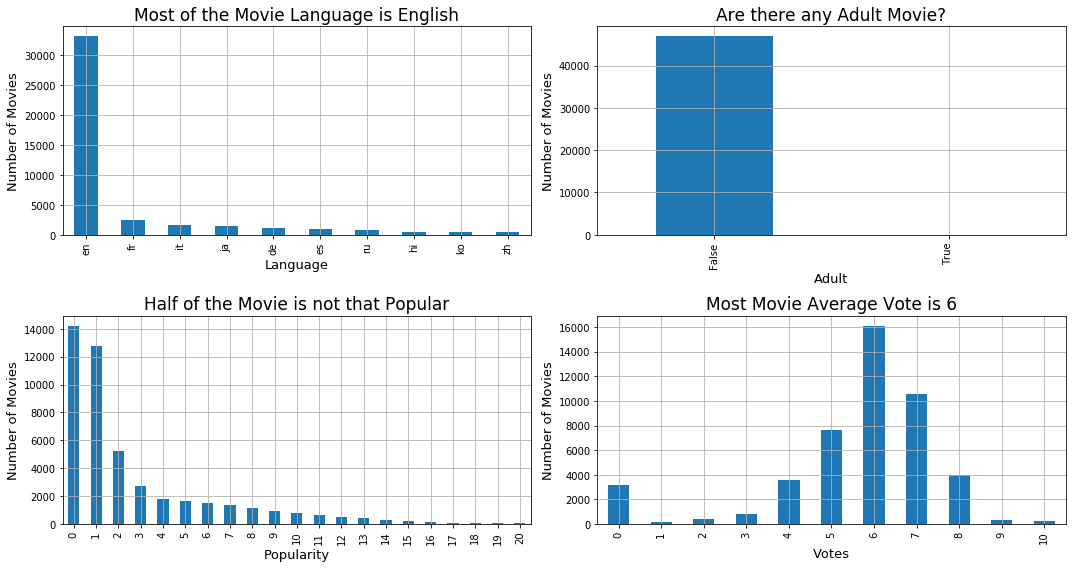

In [6]:
fig, ax = plt.subplots(2,2,figsize=(15,8));
plt1 = df['original_language'].value_counts()[0:10].plot(kind='bar',ax=ax[0,0])
plt1.set_title("Most of the Movie Language is English",fontsize = 17)
plt1.set_xlabel('Language',fontsize = 13)
plt1.set_ylabel('Number of Movies',fontsize = 13)
plt1.grid();

plt2 = df['adult'].value_counts()[0:10].plot(kind='bar',ax=ax[0,1]);
plt2.set_title("Are there any Adult Movie?",fontsize = 17)
plt2.set_xlabel('Adult',fontsize = 13)
plt2.set_ylabel('Number of Movies',fontsize = 13)
plt2.grid();

plt3 = round(df['popularity']).astype('int').value_counts()[0:21].plot(kind='bar',ax=ax[1,0]);
plt3.set_title("Half of the Movie is not that Popular",fontsize = 17)
plt3.set_xlabel('Popularity',fontsize = 13)
plt3.set_ylabel('Number of Movies',fontsize = 13)
plt3.grid();


plt4 = round(df['vote_average']).astype('int').value_counts().sort_index().plot(kind='bar',ax=ax[1,1]);
plt4.set_title("Most Movie Average Vote is 6",fontsize = 17)
plt4.set_xlabel('Votes',fontsize = 13)
plt4.set_ylabel('Number of Movies',fontsize = 13)
plt4.grid();

plt.tight_layout()

### Genres

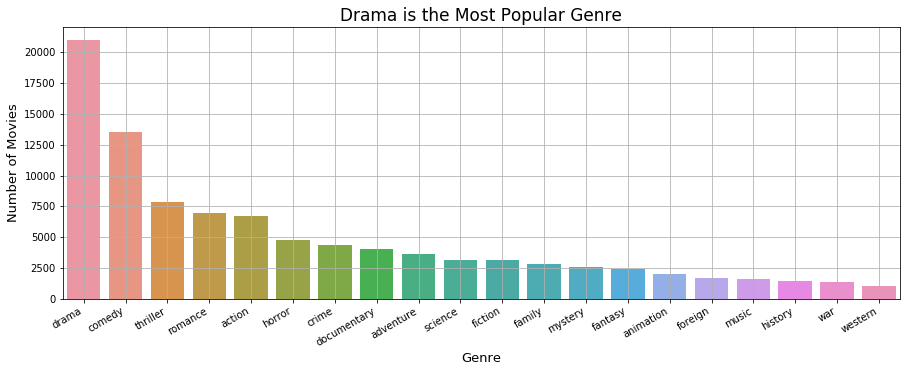

In [7]:
df['new_genres'] = df['new_genres'].apply( lambda x: re.sub('[%s]'%re.escape(string.punctuation),'',x))
df['new_genres'] = df['new_genres'].apply( lambda x: x.lower())

genres = [text for text in df['new_genres']]
genres = ' '.join(genres).split()
count_genre = Counter(genres)
top_genre = count_genre.most_common(20)
pd.DataFrame(top_genre);

genre_words = [word[0] for word in top_genre]
genre_counts = [word[1] for word in top_genre]

plt.figure(figsize = (15,5))
sns.barplot(x=genre_words, y=genre_counts)

plt.xticks(rotation=30, ha='right')
plt.title('Drama is the Most Popular Genre',fontsize = 17)
plt.xlabel('Genre',fontsize = 13)
plt.ylabel('Number of Movies',fontsize = 13)
plt.grid()
plt.show()

### Production Companies

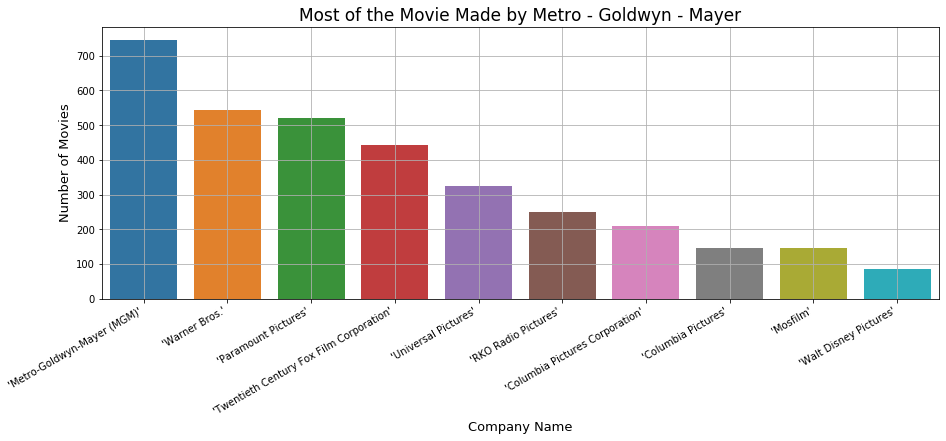

In [8]:
production_companies = [text for text in df['new_production_companies']]
count_production_companies = Counter(production_companies)
top_production_companies = count_production_companies.most_common(20)
pd.DataFrame(top_production_companies);

production_companies_words = [word[0] for word in top_production_companies]
production_companies_counts = [word[1] for word in top_production_companies]

plt.figure(figsize = (15,5))
sns.barplot(x=production_companies_words[1:11], y=production_companies_counts[1:11])

plt.xticks(rotation=30, ha='right')
plt.title('Most of the Movie Made by Metro - Goldwyn - Mayer',fontsize = 17)
plt.xlabel('Company Name',fontsize = 13)
plt.ylabel('Number of Movies',fontsize = 13)
plt.grid()
plt.show()

### Production Countries

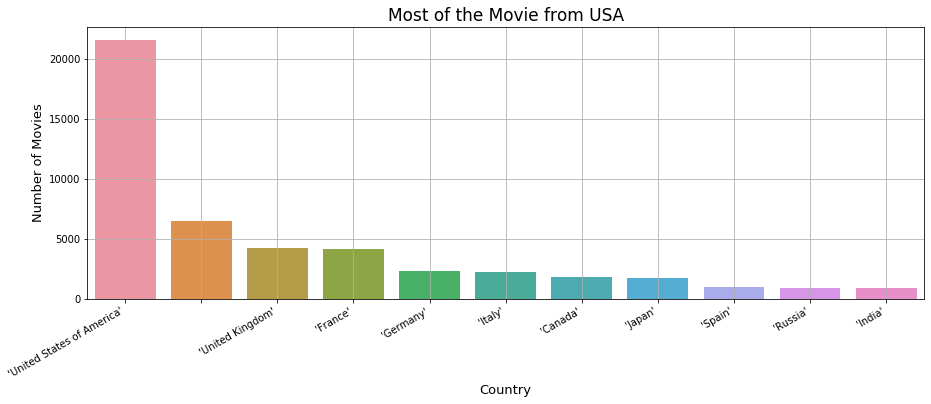

In [9]:
production_countries = [text for text in df['new_production_countries']]
countries = [] 

for i in range (0,len(production_countries)):
    x = production_countries[i].split(', ')
    countries.append(x)
    
countries = flatten(countries)   
count_production_countries = Counter(countries)
top_production_countries = count_production_countries.most_common(20)
pd.DataFrame(top_production_countries);

production_countries_words = [word[0] for word in top_production_countries]
production_countries_counts = [word[1] for word in top_production_countries]

plt.figure(figsize = (15,5))
sns.barplot(x=production_countries_words[0:11], y=production_countries_counts[0:11])

plt.xticks(rotation=30, ha='right')
plt.title('Most of the Movie from USA',fontsize = 17)
plt.xlabel('Country',fontsize = 13)
plt.ylabel('Number of Movies',fontsize = 13)
plt.grid()
plt.show()

### Spoken Languages

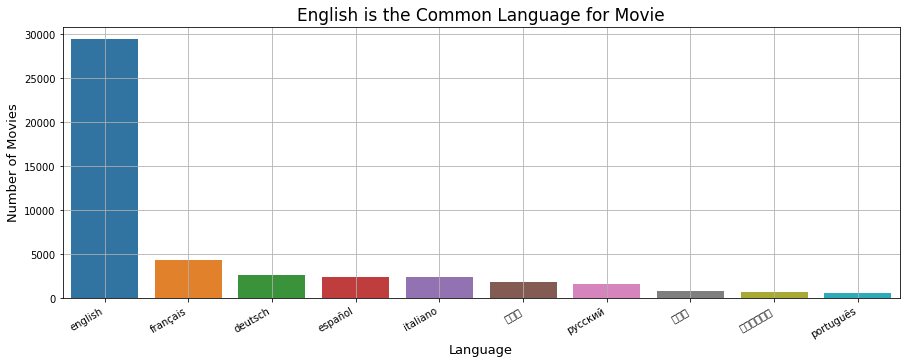

In [10]:
df['new_spoken_languages'] = df['new_spoken_languages'].apply( lambda x: re.sub('[%s]'%re.escape(string.punctuation),'',x))
df['new_spoken_languages'] = df['new_spoken_languages'].apply( lambda x: x.lower())

spoken_languages = [text for text in df['new_spoken_languages']]
spoken_languages = ' '.join(spoken_languages).split()

count_spoken_languages = Counter(spoken_languages)
top_spoken_languages = count_spoken_languages.most_common(20)
pd.DataFrame(top_spoken_languages);

spoken_languages_words = [word[0] for word in top_spoken_languages]
spoken_languages_counts = [word[1] for word in top_spoken_languages]

plt.figure(figsize = (15,5))
sns.barplot(x=spoken_languages_words[0:10], y=spoken_languages_counts[0:10])

plt.xticks(rotation=30, ha='right')
plt.title('English is the Common Language for Movie',fontsize = 17)
plt.xlabel('Language',fontsize = 13)
plt.ylabel('Number of Movies',fontsize = 13)
plt.grid()
plt.show()

### Cast

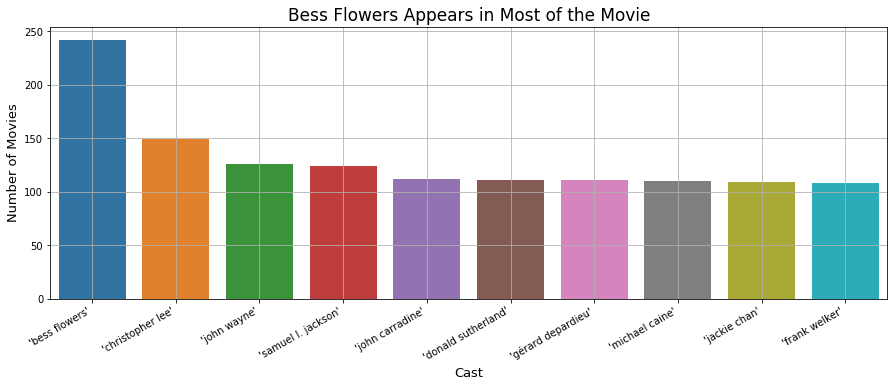

In [11]:
df['new_cast'] = df['new_cast'].apply( lambda x: x.lower())
df['new_cast'] = df['new_cast'].apply( lambda x: re.sub(('"\"'),' ',x))

cast_member = [text for text in df['new_cast']]
cast_list = [] 

for i in range (0,len(cast_member)):
    x = cast_member[i].split(', ')
    cast_list.append(x)

cast_list = flatten(cast_list)   
count_cast = Counter(cast_list)
top_cast = count_cast.most_common(20)
pd.DataFrame(top_cast);

cast_words = [word[0] for word in top_cast]
cast_counts = [word[1] for word in top_cast]

plt.figure(figsize = (15,5))
sns.barplot(x=cast_words[2:12], y=cast_counts[2:12])

plt.xticks(rotation=30, ha='right');
plt.title('Bess Flowers Appears in Most of the Movie',fontsize = 17)
plt.xlabel('Cast',fontsize = 13)
plt.ylabel('Number of Movies',fontsize = 13)
plt.grid()
plt.show()

### Keywords

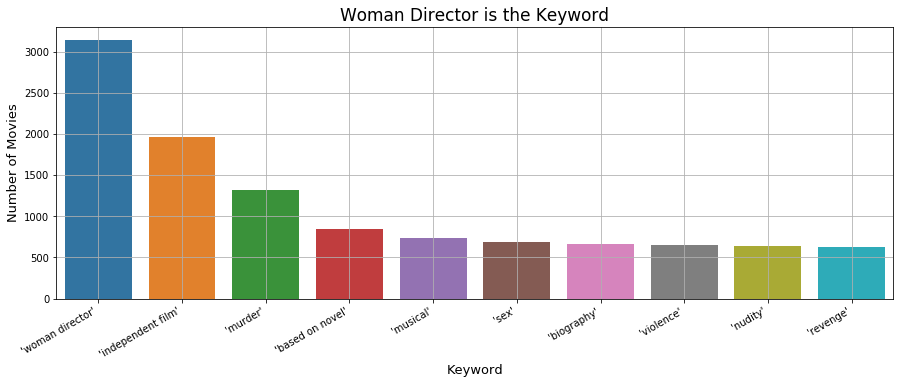

In [12]:
df['new_keywords'] = df['new_keywords'].apply( lambda x: x.lower())
keywords = [text for text in df['new_keywords']]

words = [] 
for i in range (0,len(keywords)):
    x = keywords[i].split(', ')
    words.append(x)

words = flatten(words)   
count_keywords = Counter(words)
top_keywords = count_keywords.most_common(20)
pd.DataFrame(top_keywords);

keywords_words = [word[0] for word in top_keywords]
keywords_counts = [word[1] for word in top_keywords]

plt.figure(figsize = (15,5))
sns.barplot(x=keywords_words[1:11], y=keywords_counts[1:11])

plt.xticks(rotation=30, ha='right');
plt.title('Woman Director is the Keyword',fontsize = 17)
plt.xlabel('Keyword',fontsize = 13)
plt.ylabel('Number of Movies',fontsize = 13)
plt.grid()
plt.show()

### The Rank of Movies

How do you calculate the rank of movies and TV shows on the Top Rated Movies and Top Rated TV Show lists?
The following formula is used to calculate the Top Rated 250 titles. This formula provides a true 'Bayesian estimate', which takes into account the number of votes each title has received, minimum votes required to be on the list, and the mean vote for all titles:

weighted rating (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C

Where:

R = average for the movie (mean) = (rating)

v = number of votes for the movie = (votes)

m = minimum votes required to be listed in the Top Rated list (currently 25,000)

C = the mean vote across the whole report

Reference: https://help.imdb.com/article/imdb/track-movies-tv/ratings-faq/G67Y87TFYYP6TWAV#

In [13]:
m = df['vote_count'].quantile(0.95)
m

421.0

In [14]:
C = df['vote_average'].mean()
C

5.611644524925095

In [15]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [16]:
df['weighted_rating'] = df.apply(weighted_rating, axis=1)

In [17]:
df.sort_values(by = ['weighted_rating'],ascending=False).head(5)

,index,original_title,imdbId,tmdbId,original_language,adult,popularity,vote_average,vote_count,new_genres,new_production_companies,new_production_countries,new_spoken_languages,new_cast,new_keywords,tagline,overview,combine_text,weighted_rating
314,314,The Shawshank Redemption,111161,278,en,False,51.645403,8.5,8358.0,drama crime,"'Castle Rock Entertainment', 'Warner Bros.'",'United States of America',english,"'tim robbins', 'morgan freeman', 'bob gunton',...","'prison', 'corruption', 'police brutality', 'p...",Fear can hold you prisoner. Hope can set you f...,Framed in the 1940s for the double murder of h...,framed in the 1940s for the double murder of h...,8.361488
849,849,The Godfather,68646,238,en,False,41.109264,8.5,6024.0,drama crime,"'Paramount Pictures', 'Alfran Productions'",'United States of America',english italiano latin,"'marlon brando', 'al pacino', 'james caan', 'r...","'italy', 'love at first sight', 'loss of fathe...",An offer you can't refuse.,"Spanning the years 1945 to 1955, a chronicle o...","spanning the years 1945 to 1955, a chronicle o...",8.311327
12717,12717,The Dark Knight,468569,155,en,False,123.167259,8.3,12269.0,drama action crime thriller,"'DC Comics', 'Legendary Pictures', 'Warner Bro...","'United Kingdom', 'United States of America'",english 普通话,"'christian bale', 'michael caine', 'heath ledg...","'dc comics', 'crime fighter', 'secret identity...",Why So Serious?,Batman raises the stakes in his war on crime. ...,batman raises the stakes in his war on crime. ...,8.210812
2902,2902,Fight Club,137523,550,en,False,63.869599,8.3,9678.0,drama,"'Twentieth Century Fox Film Corporation', 'Reg...","'Germany', 'United States of America'",english,"'edward norton', 'brad pitt', 'meat loaf', 'ja...","'support group', 'dual identity', 'nihilism', ...",Mischief. Mayhem. Soap.,A ticking-time-bomb insomniac and a slippery s...,a ticking-time-bomb insomniac and a slippery s...,8.187930
292,292,Pulp Fiction,110912,680,en,False,140.950236,8.3,8670.0,thriller crime,"'Miramax Films', 'A Band Apart', 'Jersey Films'",'United States of America',english español français,"'john travolta', 'samuel l. jackson', 'uma thu...","'transporter', 'brothel', 'drug dealer', 'boxe...",Just because you are a character doesn't mean ...,"A burger-loving hit man, his philosophical par...","a burger-loving hit man, his philosophical par...",8.175504


### Result:
    "The Shawshank Redemption" is the most popular Movie with the highest ranking.

# Data Analysis
Now, we need do some feature selection and to take a look at the highlight correlation table for what is doing on in the dataframe.

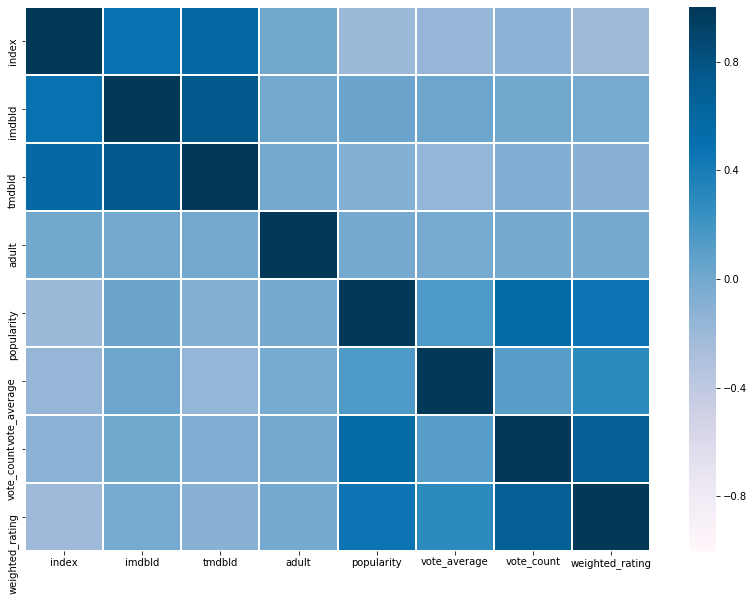

In [18]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 10)
ax=sns.heatmap(df.corr(), vmin=-1, vmax=1, cmap="PuBu", linewidths=1)

To do so, we need to follow the procedure steps for the model.

    STEP: Check the correlation > Apply VIF > Check for the coefficient and p - value

First, we need to drop all the columns that the correlation inbetween -0.3 to 0.3.

In [19]:
df.corr()[['weighted_rating']].query('weighted_rating >= 0.3 or weighted_rating <= -0.3').style.background_gradient(cmap="PuBu")

,weighted_rating
popularity,0.465227
vote_count,0.692753
weighted_rating,1


In [20]:
df.columns

Index(['index', 'original_title', 'imdbId', 'tmdbId', 'original_language',
       'adult', 'popularity', 'vote_average', 'vote_count', 'new_genres',
       'new_production_companies', 'new_production_countries',
       'new_spoken_languages', 'new_cast', 'new_keywords', 'tagline',
       'overview', 'combine_text', 'weighted_rating'],
      dtype='object')

Here, it's the data point and it separated into independent and dependent.

In [21]:
X = df[['popularity', 'vote_count']]
y = df.iloc[:,-1]

In [22]:
X_withconst = sm.add_constant(X)
sm.OLS(y.astype(float), X_withconst.astype(float)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        weighted_rating   R-squared:                       0.489
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                 2.240e+04
Date:                Tue, 05 May 2020   Prob (F-statistic):               0.00
Time:                        23:17:11   Log-Likelihood:                 17287.
No. Observations:               46910   AIC:                        -3.457e+04
Df Residuals:                   46907   BIC:                        -3.454e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.6347      0.001   6543.506      0.000       5.633       5.636
popularity     0.0044      0.000     28.162      0.000       0.004       0.005
vote_count     0.0003   1.92e-06    157.979      0.000       0.000       0.000
==============================================================================
Omnibus:                    19088.798   Durbin-Watson:                   1.678
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1625416.856
Skew:                           1.055   Prob(JB):                         0.00
Kurtosis:                      31.760   Cond. No.                         555.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
ans = pd.Series([variance_inflation_factor(X.values, i)
               for i in range(X.shape[1])], 
              index= X.columns)

We want to find if there is any multicollinearity.

The first signs of multicollinearity can be detected in the correlation between the predictors. If a regression model is to be fitted, this should always be part of the exploratory phase. If the correlation between some predictors is high, it is a sign of multicollinearity.The Variance Inflation Factor (VIF) is calculated for each predictor.

So, we need to drop any VIF value that is over 5. <br>
Then, we need to drop any p - value that is over 0.05.

In [24]:
ans.sort_values(ascending = False).apply(lambda x: '%.5f' % x)

vote_count    1.52513
popularity    1.52513
dtype: object

Let's visualize the plot between each predictor against the number of weighted rating to check if it follows a linear relationship.

In [25]:
def corrfunc(x, y, **kws):
    (r, p) = pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f} ".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)
    ax.annotate("p = {:.3f}".format(p),
                xy=(.4, .9), xycoords=ax.transAxes)

plt.rcParams["font.size"] = 15

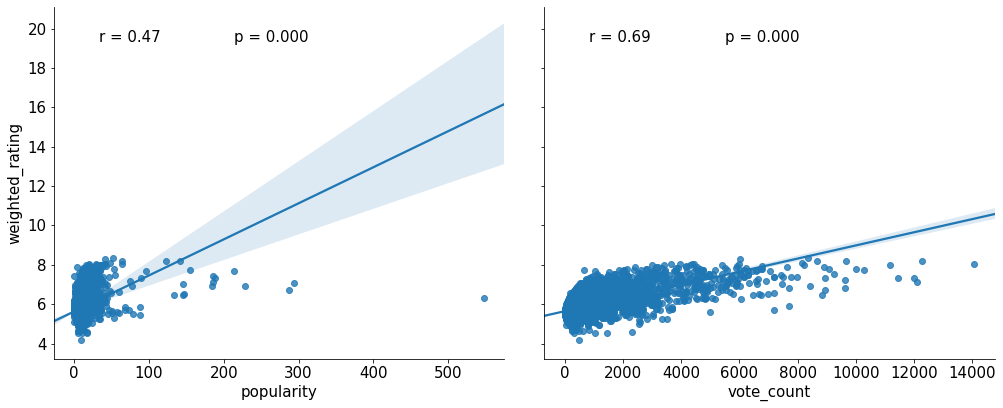

In [26]:
graph = sns.pairplot(df, x_vars=['popularity', 'vote_count'], y_vars=['weighted_rating'], 
                     height=6, aspect=1.2, kind="reg")
graph.map(corrfunc)
plt.show()

### Result: 
    By performing the independent variables along with the dependent variable, we have seen the Correlation Coefficient r between weighted_rating vs popularity is closest to +0.50 moderate uphill (positive) relationship and the Correlation Coefficient r between weighted_rating vs vote_count is  +0.7 closest to strong uphill (positive) linear relationship. It is a pretty good result.

# Recommendation_Engine

I am using cosine similarity metrics to compute the similarity between the movies and make recommendations. In Mathematically, the cosine similarity algorithm measures the similarity between two vectors by calculating the cosine of the angle between them.

In [27]:
count_matrix = CountVectorizer().fit_transform(df['combine_text'])

In [28]:
cosine_sm = cosine_similarity(count_matrix)
print(cosine_sm)
print(cosine_sm.shape)

[[1.         0.16485188 0.21282286 ... 0.14783528 0.26041025 0.25624782]
 [0.16485188 1.         0.18143706 ... 0.14833167 0.25499704 0.24431098]
 [0.21282286 0.18143706 1.         ... 0.1013799  0.39233396 0.38299072]
 ...
 [0.14783528 0.14833167 0.1013799  ... 1.         0.08457855 0.16901408]
 [0.26041025 0.25499704 0.39233396 ... 0.08457855 1.         0.57513412]
 [0.25624782 0.24431098 0.38299072 ... 0.16901408 0.57513412 1.        ]]
(46910, 46910)


This is a 46910 by 46910 matrix array. The dataframe with the index and column values as the movie name, and the row value will represent the cosine similarity between the column and the index movie. So, all the values in the diagonal matrix will be equal to the identity matrix which is 1. Otherwise, all the values inbetween the upper and lower triangular matrixs will be between 0 (no similarity) and 1 (absolute similarity).

In [29]:
sim = pd.DataFrame(cosine_sm, columns = df['original_title'], index = df['original_title'])

In [30]:
sim.head(5)

original_title,Toy Story,Jumanji,Grumpier Old Men,Waiting to Exhale,Father of the Bride Part II,Heat,Sabrina,Tom and Huck,Sudden Death,GoldenEye,...,House of Horrors,Shadow of the Blair Witch,The Burkittsville 7,Caged Heat 3000,Robin Hood,رگ خواب,Siglo ng Pagluluwal,Betrayal,Satana likuyushchiy,Queerama
original_title,,,,,,,,,,,,,,,,,,,,,
Toy Story,1.000000,0.164852,0.212823,0.197952,0.191136,0.122338,0.093030,0.249136,0.165169,0.175466,...,0.142890,0.107657,0.178665,0.264241,0.216040,0.054366,0.096907,0.147835,0.260410,0.256248
Jumanji,0.164852,1.000000,0.181437,0.245350,0.223607,0.151630,0.102951,0.207197,0.210566,0.198838,...,0.202404,0.129969,0.202112,0.223766,0.222112,0.080218,0.053621,0.148332,0.254997,0.244311
Grumpier Old Men,0.212823,0.181437,1.000000,0.217197,0.210655,0.184568,0.073100,0.241604,0.203880,0.224612,...,0.141539,0.145417,0.215548,0.347970,0.342502,0.124274,0.027690,0.101380,0.392334,0.382991
Waiting to Exhale,0.197952,0.245350,0.217197,1.000000,0.242960,0.213497,0.106809,0.251367,0.151707,0.233689,...,0.120307,0.089893,0.239317,0.323167,0.272044,0.166450,0.055631,0.158417,0.267272,0.328150
Father of the Bride Part II,0.191136,0.223607,0.210655,0.242960,1.000000,0.159841,0.138123,0.209235,0.209262,0.194520,...,0.188579,0.135622,0.235793,0.261549,0.234533,0.071750,0.059950,0.175595,0.265568,0.253637


In [31]:
def movie_recommendation(movie_name):
    
    recommended_movies = pd.DataFrame(sim[movie_name].sort_values(ascending=False)[1:6])
    recommended_movies = recommended_movies.rename_axis("Similar Movies")
   
    return recommended_movies

In [32]:
movie_recommendation('Toy Story')

,Toy Story
Similar Movies,
Toy Story 2,0.555091
Toy Story 3,0.485058
Toy Story That Time Forgot,0.411089
Small Fry,0.389893
La luna,0.387015


In [33]:
movie_recommendation('Star Wars')

,Star Wars
Similar Movies,
The Empire Strikes Back,0.464253
Return of the Jedi,0.429333
Hawk the Slayer,0.375847
The Lost Tribe,0.372928
Empire of Dreams: The Story of the Star Wars Trilogy,0.371820


In [34]:
movie_recommendation('Apollo 13')

,Apollo 13
Similar Movies,
From the Earth to the Moon,0.514645
Apollo 13: To the Edge and Back,0.495376
For All Mankind,0.488470
The Work and the Glory II: American Zion,0.487185
Fantasía... 3,0.486075


In [35]:
movie_recommendation('Superman Returns')

,Superman Returns
Similar Movies,
All Star Superman,0.526288
Superman/Batman: Public Enemies,0.500638
LEGO DC Comics Super Heroes: Justice League: Attack of the Legion of Doom!,0.495751
Don't Blink: Robert Frank,0.485838
Superman: Unbound,0.479767


The recommendation engine can provide recommendations even when we don’t have any user data. Therefore, I will build a Movie Collaborative Filtering base on user rating on a separate notebook. 